# Data608 Final Project

Jois Xie, Ling Cai



In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [120]:
## let's obtain a spark context and load a DataFrame from a file.

# Please make sure that you are using an appropriate allocation.

import os
import atexit
import sys

import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
import findspark
from sparkhpc import sparkjob

#Exit handler to clean up the Spark cluster if the script exits or crashes
def exitHandler(sj,sc):
    try:
        print('Trapped Exit cleaning up Spark Context')
        sc.stop()
    except:
        pass
    try:
        print('Trapped Exit cleaning up Spark Job')
        sj.stop()
    except:
        pass

findspark.init()

#Parameters for the Spark cluster
nodes=3
tasks_per_node=8 
memory_per_task=1024 #1 gig per process, adjust accordingly
# Please estimate walltime carefully to keep unused Spark clusters from sitting 
# idle so that others may use the resources.
walltime="5:00" #3 hours


os.environ['SBATCH_PARTITION']='lattice' #Set the appropriate ARC partition
# os.environ['SBATCH_RESERVATION']='data608_apr10'


sj = sparkjob.sparkjob(
     ncores=nodes*tasks_per_node,
     cores_per_executor=tasks_per_node,
     memory_per_core=memory_per_task,
     walltime=walltime
    )

sj.wait_to_start()
sc = sj.start_spark()

#Register the exit handler                                                                                                     
atexit.register(exitHandler,sj,sc)

#You need this line if you want to use SparkSQL
sqlCtx=SQLContext(sc)
print( sc.uiWebUrl )


In [63]:
## Some initializations for bokeh

from bokeh.models import ColumnDataSource
from bokeh.plotting import *

from bokeh.io import push_notebook, show, output_notebook
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6

import numpy as np

## In order to have plots show up within the notebook, the following call is needed.
output_notebook()
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.types import *




# print('done')

Loading BokehJS ...

In [64]:
import os
import atexit
import sys

import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
import findspark
from sparkhpc import sparkjob
sqlCtx=SQLContext(sc)
print( sc.uiWebUrl )
## Load a Dataframe from a parquet file

df = sqlCtx.read.csv('regressor608.csv',header = True, inferSchema = True)
df = df.withColumnRenamed('8.1A_ON-SITE_CONTAINED_REL.', 'R81A')
df = df.withColumnRenamed('8.1B_ON-SITE_OTHER_RELEASES', 'R81B')
df = df.withColumnRenamed('8.1C_OFF-SITE_CONTAINED_REL.', 'R81C')
df = df.withColumnRenamed('8.1D_OFF-SITE_OTHER_RELEASES', 'R81D')
df = df.withColumnRenamed('8.1D_OFF-SITE_OTHER_RELEASES', 'R81D')
df.printSchema()
df.cache()
# df.describe().toPandas()

http://cn011:4040
root
 |-- TOTAL_RELEASES: double (nullable = true)
 |-- T61TREATMENT: double (nullable = true)
 |-- R81A: double (nullable = true)
 |-- R81B: double (nullable = true)
 |-- R81C: double (nullable = true)
 |-- R81D: double (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- FACILITY_NAME: string (nullable = true)
 |-- PARENT_COMPANY_NAME: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- INDUSTRY_SECTOR: string (nullable = true)
 |-- CHEMICAL: string (nullable = true)
 |-- ST: string (nullable = true)



DataFrame[TOTAL_RELEASES: double, T61TREATMENT: double, R81A: double, R81B: double, R81C: double, R81D: double, YEAR: int, FACILITY_NAME: string, PARENT_COMPANY_NAME: string, LATITUDE: double, LONGITUDE: double, INDUSTRY_SECTOR: string, CHEMICAL: string, ST: string]

# Toxics Release Inventory Program and Data

The Toxics Release Inventory (TRI) is a publicly available database containing information on toxic chemical releases and other waste management activities in the United States, administered by Environmental Protection Agency (EPA). It is a resource for learning about toxic chemical releases and pollution prevention activities reported by industrial and federal facilities. All facilities, regardless of their size, are required to report their chemical release information to TRI. 

With this information, we decided to conduct two themes of analysis. 
    1. A narrow view of the U.S. Economy
    2. Apply Machine learning techniques to do classification and regression. 


## Data Review
The original data is avaiable in https://www.epa.gov/toxics-release-inventory-tri-program/tri-basic-data-files-calendar-years-1987-2017.  We have downloaded the data of years 2000 - 2017. Each year is a file. In total we have 18 files (18 years). 

There are 115 columns in each data file. The combined rows of all years is about 1.5 million rows. 




## Column and Row Selection

At the first glance, the file seemed overwhelming with 115 columns. Upon reviewing the data explanation document, we were able to delete the non-applicable columns.  We used the multiprocessing methods to read/load the data, and select columns. 

The completed file was uploaded to Arc for further analysis. File name: 608regressor.csv. 

## Sequential and Multiprocessing Time Comparison

The result comparison is shown below. 

For multiprocessing, we tried different parameters for the number of processes. The conclusion is that 4 was the best number. 

In [65]:
time_parallel = 99
time_multiprocessing = 24.2

Lname = ['Parallel', 'Multiprocessing']
Lvalue = [time_parallel, time_multiprocessing]
resultdf = pd.DataFrame({'Type': Lname, 'Time(second)':Lvalue})
display(resultdf)

,Type,Time(second)
0,Parallel,99.0
1,Multiprocessing,24.2


# Subject 1. A Narrow View of the U.S. Economy

How has the U.S. economy been doing? This database, though not a complete list of all industies in the U.S., are the industries that majority of the hands-on jobs. These industries are the bread-and-butter for the Americans.  We will look at some raw numbers of this dataset to see the trends. 

### How's the U.S. Economy? Is the U.S. Monopolizing? 

In a capitalism society, monopoly is an extreme result of free-market economy. When a single company or group becomes large enough to own all or nearly all of the market (goods, supplies, commodities, infrastructure and assets) for a particular type of product or service, this situation is considered monopoly. So, is the U.S. monopolizing? 




In [66]:


df_company_st = df.select('FACILITY_NAME', 'PARENT_COMPANY_NAME', 'YEAR', 'ST').groupby('YEAR','ST').agg(countDistinct('FACILITY_NAME').alias('num_of_facility'), countDistinct('PARENT_COMPANY_NAME').alias('num_of_parent'))
df_company_st=df_company_st.withColumn("ratio", col("num_of_facility") /  col("num_of_parent"))
# df_company_st.show(2)
df_company_st_compare = df_company_st.where((df_company_st.YEAR == 2000) | (df_company_st.YEAR ==2017))
# df_company_st_compare.show(2)

The following table shows the number of facilitis and their parent-companies by year (2000 - 2017). 

In [67]:

# to plot num of facility/parent by year, color coded. 

df_company = df.select('FACILITY_NAME', 'PARENT_COMPANY_NAME', 'YEAR').groupby('YEAR').agg(countDistinct('FACILITY_NAME').alias('num_of_facility'), countDistinct('PARENT_COMPANY_NAME').alias('num_of_parent'))
df_company=df_company.withColumn("ratio", col("num_of_facility") /  col("num_of_parent"))
# df_company.printSchema()
# df_company.toPandas().describe()

df_company = df_company.sort(df_company.YEAR, ascending=True)
pd_df_company = df_company.toPandas()
display(pd_df_company.head(18))


,YEAR,num_of_facility,num_of_parent,ratio
0,2000,20678,6844,3.021333
1,2001,22106,7007,3.154845
2,2002,21595,6806,3.172936
3,2003,21181,6603,3.207784
4,2004,20994,6450,3.254884
5,2005,18750,5875,3.191489
6,2006,20374,6174,3.299968
7,2007,19859,5925,3.351730
8,2008,19375,5704,3.396739
9,2009,18654,5386,3.463424


In [68]:
from bokeh.models import ColumnDataSource, ranges, LabelSet
YEAR = df_company.select("YEAR").rdd.flatMap(lambda x: x).collect()
YEAR = [str(yr) for yr in YEAR]
num_of_facility = df_company.select("num_of_facility").rdd.flatMap(lambda x: x).collect()
num_of_parent = df_company.select("num_of_parent").rdd.flatMap(lambda x: x).collect()

templist = ['num_of_facility', 'num_of_parent']
x = [ (yr, cat) for yr in YEAR for cat in templist ]
# print(x)
ynum = [j for i in zip(num_of_facility,num_of_parent) for j in i]
ynum = tuple(ynum)

source = ColumnDataSource(data=dict(x=x, ynum=ynum))


labels = LabelSet(x='x', y='ynum', text='ynum', level='glyph',source=source, text_font_size="7pt",  
                  render_mode='css', text_align = 'center'
#         x_offset=-13.5, y_offset=0, source=source, render_mode='canvas'
                 )

p = figure(x_range=FactorRange(*x), plot_height=550,plot_width = 900,
           title="Number of Facilities / Parent Facilities by Year")

p.vbar(x='x', top='ynum', width=0.9, source=source, line_color="white",
       # use the palette to colormap based on the the x[1:2] values
       fill_color=factor_cmap('x', palette=Spectral6, factors=templist, start=1, end=2))


p.add_layout(labels)

p.xaxis.major_label_orientation = "vertical"
show(p)





Overall, number of facilities are gradually reducing. Same as their parent facilities. In 2001, the peak year, there were 22106 facilities in the country, while in 2017 (the latest year), only 18185 left. This means there are net 3921 facilities that have shut down. A net 17.7% reduction. 

The number of these facilities' parent companies is reducing as well. In 2001 there were 7007 comapnies, while 2017 only 4682 left. A net reduction of 2325 parent companies, 33% reduction. 

These facilities were probably permanently shut down due to poor economy, or moved overseas to countires where worker salary is lower, and the local Environment, Health & Safety regulations were under developement. 

With such numbers, it's not surprising to see the unemployment rate in the U.S. has been the focus point all the time, especailly during the election years.  



In [69]:
## geo map 1
# create a dataframe with only DC in 2000 and 2017 only. 
df = sqlCtx.read.csv('regressor608.csv',header = True, inferSchema = True)
df = df.filter((df['YEAR']== 2000) | (df['YEAR']== 2017))
# df = df.filter(df["ST"]=='DC')
df_dc = df.select(['LONGITUDE', 'LATITUDE', 'FACILITY_NAME', 'YEAR', 'ST'])
# df_dc.show(20)
pd_df_dc = df_dc.toPandas()
# display(pd_df_dc.head(20))
# df_dc.cache()


In [70]:
# geo map 2
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# Schema of output columns
schema = StructType([
    StructField("x", DoubleType()),
    StructField("y", DoubleType())
])

import math
# (lat, lon) to mercator conversion code from:
# https://gis.stackexchange.com/questions/156035/calculating-mercator-coordinates-from-lat-lon/156046

def merc(lat, lon):
    if( math.fabs(lat) > 1e-6 and math.fabs(lon) > 1e-6):
        r_major = 6378137.000
        x = r_major * math.radians(lon)
        scale = x/lon
        fac = math.tan(math.pi/4.0 + lat * (math.pi/180.0)/2.0)
        if fac > 0.0:
            y = 180.0/math.pi * math.log( fac ) * scale
            return (x, y)
        else:
            return (0.0, 0.0)
    else:
        return (0.0, 0.0)
    

# Register the UDF
merc_udf = udf(merc, schema)

# Apply the UDF and flatten the table

serverdf = df_dc.withColumn('pickup_merc_coords', 
                            merc_udf(df_dc.LATITUDE, df_dc.LONGITUDE)).select('LATITUDE', 'LONGITUDE', 'pickup_merc_coords.*', 'YEAR', 'FACILITY_NAME')

# serverdf.show(1)
serverdf.cache()

DataFrame[LATITUDE: double, LONGITUDE: double, x: double, y: double, YEAR: int, FACILITY_NAME: string]

In [71]:
def merc(lat, lon):
    if( math.fabs(lat) > 1e-6 and math.fabs(lon) > 1e-6):
        r_major = 6378137.000
        x = r_major * math.radians(lon)
        scale = x/lon
        fac = math.tan(math.pi/4.0 + lat * (math.pi/180.0)/2.0)
        if fac > 0.0:
            y = 180.0/math.pi * math.log( fac ) * scale
            return (x, y)
        else:
            return (0.0, 0.0)
    else:
        return (0.0, 0.0)
print(merc(39.42, -125.43))

(-13962803.730200306, 4782012.781276048)


In [72]:
# geo map 3
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.io import output_file, show
from bokeh.models.widgets import CheckboxButtonGroup
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# output_notebook()


localdf = serverdf.filter(serverdf.YEAR ==2000).toPandas()



In [73]:
# geo map 4
def update_year(x=2000):
    global serverdf
    global selected_year
    localdf = serverdf[serverdf['YEAR'] == x].toPandas()
    data_handle.data_source.data['x'] = localdf['x'].values
    data_handle.data_source.data['y'] = localdf['y'].values
    print(x)
    push_notebook(handle=geo_plot)
    
interact_manual(update_year, 
                x=widgets.BoundedIntText(value=2000,min=2000,max=2017,step = 17,
                                                  description='Select Year:' ))
output_notebook()


geop = figure(x_range=(-7497367, -13962803.73), y_range=( 1782012, 4782012.78), x_axis_type="mercator", y_axis_type="mercator",
          plot_width=800, plot_height=400, title = 'Facilities Map')  
 
geop.add_tile(CARTODBPOSITRON)

data_handle = geop.circle(x=localdf['x'].values, y=localdf['y'].values, size=3, fill_color="blue", fill_alpha=0.1)

geo_plot = show(geop,  notebook_handle=True)

interactive(children=(BoundedIntText(value=2000, description='Select Year:', max=2017, min=2000, step=17), But…

Loading BokehJS ...

The Map wasn't able to give us enough information. 




Let's review the trend of facility/parent company ratio. 

    Ratio = number of facilities / number of parent companies

In [74]:
display(pd_df_company.head(18))
ratio= pd_df_company['ratio'].values

TOOLTIPS = [("Year", "@{x}{f}"),("Ratio", "Avg $y{f.2f} facilities/parent company")] 
p = figure(title="Facility/Parent Ratio by Year", plot_width=800, plot_height=400,  tooltips=TOOLTIPS)
p.line(x=YEAR, y=ratio, color = 'orange')
show(p)

,YEAR,num_of_facility,num_of_parent,ratio
0,2000,20678,6844,3.021333
1,2001,22106,7007,3.154845
2,2002,21595,6806,3.172936
3,2003,21181,6603,3.207784
4,2004,20994,6450,3.254884
5,2005,18750,5875,3.191489
6,2006,20374,6174,3.299968
7,2007,19859,5925,3.351730
8,2008,19375,5704,3.396739
9,2009,18654,5386,3.463424


In 2000, on average, one parent company owned 3.02 facilities. In 2017, this ratio has increased to 3.88. In addition, the ratio has been steadily increasing.There is an obvious trend of monopoly. This is somehow explanable by the economy - when the economy is bad, small business (facility sites) have a hard time surviving. They were either merged among themselves, or acquired by bigger corporate companies. 

Let's zoom in to the state level. 

The top 5 and bottom 5 states are: 

In [75]:
## Create a dataframe df_co_ratio_delta to show ratio delta between 2017 and 2000 - Do not delete
## do not delete
df_company_st_compare2000 = df_company_st_compare.filter(df_company_st_compare.YEAR ==2000)
# df_company_st_compare2000.show(5)
df_company_st_compare2000 = df_company_st_compare2000.withColumnRenamed('ratio', 'ratio2000')
df_company_st_compare2000 = df_company_st_compare2000.drop('num_of_facility', 'num_of_parent', 'YEAR')


df_company_st_compare2017 = df_company_st_compare.filter(df_company_st_compare.YEAR ==2017)
df_company_st_compare2017 = df_company_st_compare2017.withColumnRenamed('ratio', 'ratio2017')
df_company_st_compare2017 = df_company_st_compare2017.drop('num_of_facility', 'num_of_parent', 'YEAR')
# df_company_st_compare2017.show(5)

In [76]:
df_co_ratio_delta = df_company_st_compare2000.join(df_company_st_compare2017, ["ST"])

# df_co_ratio_delta = df_company_st_compare2000.join(df_company_st_compare2017, df_company_st_compare2000.ST == df_company_st_compare2017.ST)
df_co_ratio_delta=df_co_ratio_delta.withColumn("ratio_delta", col("ratio2017") - col("ratio2000"))
# df_co_ratio_delta = df_co_ratio_delta.drop('ratio2000', 'ratio2017')
# df_co_ratio_delta.show(1)
# df_co_ratio_delta.printSchema()
# display(df_co_ratio_delta.toPandas().head(57))
pd_df_co_ratio_delta = df_co_ratio_delta.toPandas()
pd_df_co_ratio_delta = pd_df_co_ratio_delta.sort_values(by=['ratio_delta'])
display(pd_df_co_ratio_delta.head(5))
display(pd_df_co_ratio_delta.tail(5))

# when reconnected, run this cell. 

,ST,ratio2000,ratio2017,ratio_delta
8,RI,1.888889,1.666667,-0.222222
9,KY,1.553191,1.460714,-0.092477
4,NJ,1.849693,1.792553,-0.057140
54,UT,1.629630,1.615385,-0.014245
34,OH,1.973684,1.966981,-0.006703


,ST,ratio2000,ratio2017,ratio_delta
28,GU,1.666667,2.250000,0.583333
41,TX,1.877984,2.466089,0.588105
48,FL,2.105263,2.728507,0.623244
55,HI,1.764706,2.500000,0.735294
5,DC,1.166667,2.000000,0.833333


In [77]:
from pyspark.sql.functions import *
df_co_ratio_delta = df_co_ratio_delta.sort(desc("ratio_delta"))

ST= df_co_ratio_delta.select("ST").rdd.flatMap(lambda x: x).collect()
# print(ST)
ratio_delta = df_co_ratio_delta.select("ratio_delta").rdd.flatMap(lambda x: x).collect()
# print(ratio_delta)

p = figure(x_range=ST, plot_height=350, plot_width = 1000, 
           title="Facility/Parent ratio difference by State (2000-2017)"
          )  #check here when reconnected
p.vbar(x=ST, top=ratio_delta, width=0.6, color = 'orange' )
p.xgrid.grid_line_color = None
p.y_range.start = -0.3
show(p)

In DC, on average, in 2000, one parent company owned 1.17 facilities. In 2017, one parent ccompany owned 2.00 faiclities. The difference was 0.83 facilities / parent company. 


Of all the states in the U.S., DC has the highest increase of the facility/parent ratio. If you had you been in the DC, there was a higher chance that your facility would have been shut down / acquired / merged. 

# Subject 2. Chemical Release and Industry Sector

In this subject, we would like to apply the machine learning technique. We conduct the classification and regression methods both in Spark and in local machine to compare the performance. 


## 2.0 Data Study

In addition, with the advantage of this data size (1.5 million rows) still being small, we were still able to use Tableau to quickly plot charts and study the data. We first looked at the top chemical with the highest release amount, then reivewed the industry sector composition in those chemicals, then identified the most 3 industry sectors with the most diversed chemicals. We then picked these three chemicals for classification and regression study. 

## 2.1 Classification Prediction

### 2.1.0 Data Preparation

The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

In [78]:
# 1. load data. 
df = sqlCtx.read.csv('regressor608.csv',header = True, inferSchema = True)
# df.printSchema()
df.cache()

# change some long column names to shorter names
df = df.withColumnRenamed("8.1A_ON-SITE_CONTAINED_REL.", "onsitetype1")
df = df.withColumnRenamed("8.1B_ON-SITE_OTHER_RELEASES", "onsitetype2")
df = df.withColumnRenamed("8.1C_OFF-SITE_CONTAINED_REL.", "offsitetype1")
df = df.withColumnRenamed("8.1D_OFF-SITE_OTHER_RELEASES", "offsitetype2")

Data Processing: 

    First index each categorical column using the StringIndexer, then convert the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

In [79]:
# 2. Make a clean dataframe: drop some useless columns, OneHot Encode some columns
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

df_classification = df.drop('YEAR', 'FACILITY_NAME','PARENT_COMPANY_NAME','LATITUDE','LONGITUDE','ST','TOTAL_RELEASES','T61TREATMENT')
df_classification = df_classification.filter((df_classification['INDUSTRY_SECTOR'] == 'Food') | (df_classification['INDUSTRY_SECTOR'] =='Beverages') | (df_classification['INDUSTRY_SECTOR'] =='Fabricated Metals'))

categoricalColumns = ['CHEMICAL']
stages = []
chem = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'INDUSTRY_SECTOR', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['onsitetype1', 'onsitetype2', 'offsitetype1', 'offsitetype2']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
# df_classification.show()
# print(stages)
# print(assembler)
# print(assemblerInputs)
cols = df_classification.columns
pd_df_classification = df_classification.toPandas()
display(pd_df_classification.head(1))



,onsitetype1,onsitetype2,offsitetype1,offsitetype2,INDUSTRY_SECTOR,CHEMICAL
0,0.0,0.0,0.0,0.0,Fabricated Metals,NITRIC ACID


We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

In [80]:
# 3. Feed into pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_classification)
df_classification = pipelineModel.transform(df_classification)

selectedCols = ['label', 'features'] + cols
df_classification = df_classification.select(selectedCols)
pd_df_classification = df_classification.toPandas()
display(pd_df_classification.head(1))

# df_classification.printSchema()

,label,features,onsitetype1,onsitetype2,offsitetype1,offsitetype2,INDUSTRY_SECTOR,CHEMICAL
0,0.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,Fabricated Metals,NITRIC ACID


Randomly split data into train and test sets, and set seed for reproducibility.

In [81]:
# 4. Train/Test split
train, test = df_classification.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 151827
Test Dataset Count: 65269


In [82]:
# 5. change features to length of feature
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

slen = udf(lambda s: len(s), IntegerType())
df_classification2 = df_classification.withColumn("features", slen(df_classification.features))
df_classification2.show(1)

+-----+--------+-----------+-----------+------------+------------+-----------------+-----------+
|label|features|onsitetype1|onsitetype2|offsitetype1|offsitetype2|  INDUSTRY_SECTOR|   CHEMICAL|
+-----+--------+-----------+-----------+------------+------------+-----------------+-----------+
|  0.0|     199|        0.0|        0.0|         0.0|         0.0|Fabricated Metals|NITRIC ACID|
+-----+--------+-----------+-----------+------------+------------+-----------------+-----------+
only showing top 1 row



### 2.1.1 Decision Tree Classifier

In [83]:
%%time
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train, test = df_classification.randomSplit([0.8, 0.2], seed = 2018)
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df_classification)
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df_classification)

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
DecisionTreeClassifier_accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g " % DecisionTreeClassifier_accuracy)

treeModel = model.stages[2]
# summary only
print(treeModel)

+----------+------------+---------------+
|prediction|indexedLabel|       features|
+----------+------------+---------------+
|       0.0|         0.0|(199,[0],[1.0])|
|       0.0|         0.0|(199,[0],[1.0])|
|       0.0|         0.0|(199,[0],[1.0])|
|       0.0|         0.0|(199,[0],[1.0])|
|       0.0|         0.0|(199,[0],[1.0])|
+----------+------------+---------------+
only showing top 5 rows

Test Accuracy = 0.794966 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_c9cb4a108a90) of depth 5 with 35 nodes
CPU times: user 56.8 ms, sys: 18 ms, total: 74.8 ms
Wall time: 6.97 s


In [128]:
DecisionTreeClassifier_time = 6.97

In [85]:
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabel = predictions.select("prediction", "label").rdd

# Generate confusion matrix
metrics = MulticlassMetrics(predictionAndLabel)
print('0:Fabricated Metals 1:Food 2:Beverages')
print('')
print (metrics.confusionMatrix())



0:Fabricated Metals 1:Food 2:Beverages

DenseMatrix([[27529.,  2578.,     0.],
             [ 5802.,  6963.,     0.],
             [  274.,   242.,     0.]])


#### Results


In [129]:
print('DecisionTreeClassifier Accuracy is', DecisionTreeClassifier_accuracy)
print('Run time is', DecisionTreeClassifier_time)

DecisionTreeClassifier Accuracy is 0.7949663501428966
Run time is 6.97


### 2.1.2 Multilayer Perceptron Classifier
Multilayer perceptron classifier (MLPC) is a classifier based on the feedforward artificial neural network. MLPC consists of multiple layers of nodes. Each layer is fully connected to the next layer in the network. Nodes in the input layer represent the input data. All other nodes map inputs to outputs by a linear combination of the inputs with the node’s weights w and bias b and applying an activation function. 

In [87]:
%%time
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split the data into train and test
train, test = df_classification.randomSplit([0.8, 0.2], seed = 2018)

# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [199,5,4,3]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))
MultilayerPerceptronClassifier_accuracy = str(evaluator.evaluate(predictionAndLabels))

Test set accuracy = 0.8245367382686457
CPU times: user 42.8 ms, sys: 5.76 ms, total: 48.6 ms
Wall time: 25.6 s


In [130]:
MultilayerPerceptronClassifier_time = 25.6

#### Results


In [131]:
print('Multilayer Perceptron Classifier accuracy is', MultilayerPerceptronClassifier_accuracy)
print('Run time is', MultilayerPerceptronClassifier_time)

Multilayer Perceptron Classifier accuracy is 0.8245367382686457
Run time is 25.6


### 2.1.3 Random Forrest Classifier
Random forests are a popular family of classification and regression methods.

In [90]:
%%time
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train, test = df_classification.randomSplit([0.8, 0.2], seed = 2018)

labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df_classification)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=19).fit(df_classification)

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
RandomForestClassifier_accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % RandomForestClassifier_accuracy)

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+---------------+
|predictedLabel|label|       features|
+--------------+-----+---------------+
|           0.0|  0.0|(199,[0],[1.0])|
|           0.0|  0.0|(199,[0],[1.0])|
|           0.0|  0.0|(199,[0],[1.0])|
|           0.0|  0.0|(199,[0],[1.0])|
|           0.0|  0.0|(199,[0],[1.0])|
+--------------+-----+---------------+
only showing top 5 rows

Test Accuracy = 0.706071
RandomForestClassificationModel (uid=RandomForestClassifier_46e6a1456509) with 10 trees
CPU times: user 64.7 ms, sys: 21 ms, total: 85.6 ms
Wall time: 5.65 s


In [133]:
RandomForestClassifier_time = 5.65

In [92]:
# var_imp = rfModel.featureImportances
var_imp = rfModel.featureImportances
var_imp

SparseVector(199, {0: 0.0397, 1: 0.041, 2: 0.0418, 3: 0.1618, 5: 0.0239, 6: 0.0799, 8: 0.0969, 9: 0.0252, 10: 0.0787, 11: 0.0092, 12: 0.028, 13: 0.0112, 17: 0.1186, 20: 0.0246, 21: 0.0578, 26: 0.0504, 28: 0.0039, 29: 0.0191, 31: 0.0034, 47: 0.0111, 52: 0.0109, 195: 0.0, 196: 0.0107, 198: 0.0521})

<Figure size 1440x1440 with 0 Axes>

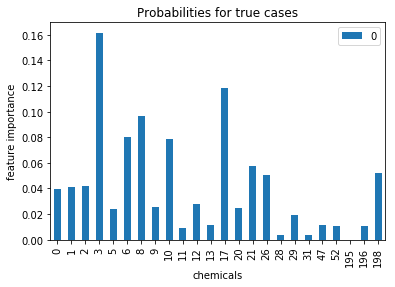

In [93]:
from  pyspark.mllib.linalg import SparseVector
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(var_imp.toArray())
df = df[df[0] > 0]
plt.figure(figsize = (20, 20))
#plt.bar()
df.plot.bar()
plt.xlabel('chemicals')
plt.ylabel('feature importance')
plt.title('Probabilities for true cases')
# plt.grid(True)
plt.show()

In [94]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabel = predictions.select("prediction", "label").rdd

# Generate confusion matrix
metrics = MulticlassMetrics(predictionAndLabel)
print('0:Fabricated Metals 1:Food 2:Beverages')
print('')
print (metrics.confusionMatrix())



0:Fabricated Metals 1:Food 2:Beverages

DenseMatrix([[30066.,    41.,     0.],
             [12196.,   569.,     0.],
             [  473.,    43.,     0.]])


#### Results


In [134]:
print('RandomForestClassifier accuracy is', RandomForestClassifier_accuracy)
print('Run time is', RandomForestClassifier_time)

RandomForestClassifier accuracy is 0.706070802987001
Run time is 5.65


### 2.1.4 Naive Bayes
Naive Bayes classifiers are a family of simple probabilistic, multiclass classifiers based on applying Bayes’ theorem with strong (naive) independence assumptions between every pair of features.
Naive Bayes can be trained very efficiently. With a single pass over the training data, it computes the conditional probability distribution of each feature given each label. For prediction, it applies Bayes’ theorem to compute the conditional probability distribution of each label given an observation.

In [96]:
%%time
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train, test = df_classification.randomSplit([0.8, 0.2], seed = 2018)

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# train the model
model = nb.fit(train)

# select example rows to display.
predictions = model.transform(test)
# predictions.show()

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
NaiveBayesClassifier_accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(NaiveBayesClassifier_accuracy))

Test set accuracy = 0.5729925324974647
CPU times: user 21 ms, sys: 4.11 ms, total: 25.2 ms
Wall time: 2.22 s


In [135]:
NaiveBayesClassifier_time = 2.22

#### Results


In [136]:
print('NaiveBayesClassifier accuracy is', NaiveBayesClassifier_accuracy)
print('Run time is', NaiveBayesClassifier_time)

NaiveBayesClassifier accuracy is 0.5729925324974647
Run time is 2.22


### 2.1.5 One-vs-Rest classifier (a.k.a. One-vs-All)
OneVsRest is an example of a machine learning reduction for performing multiclass classification given a base classifier that can perform binary classification efficiently. It is also known as “One-vs-All.”
OneVsRest is implemented as an Estimator. For the base classifier, it takes instances of Classifier and creates a binary classification problem for each of the k classes. The classifier for class i is trained to predict whether the label is i or not, distinguishing class i from all other classes.
Predictions are done by evaluating each binary classifier and the index of the most confident classifier is output as label.

In [99]:
%%time
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train, test = df_classification.randomSplit([0.8, 0.2], seed = 2018)

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(train)

# score the model on test data.
predictions = ovrModel.transform(test)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# compute the classification error on test data.
One_vs_Rest_Classifier_accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % One_vs_Rest_Classifier_accuracy)

Test Accuracy = 0.843067
CPU times: user 210 ms, sys: 59 ms, total: 269 ms
Wall time: 14.2 s


In [137]:
One_vs_Rest_Classifier_time = 14.2

#### Results


In [138]:
print('One_vs_Rest_Classifier accuracy is', One_vs_Rest_Classifier_accuracy)
print('Run time is', One_vs_Rest_Classifier_time)

One_vs_Rest_Classifier accuracy is 0.8430672075228174
Run time is 14.2


## Comparison


In [139]:

Lname = ['DecisionTreeClassifier', 'RandomForestClassifier', 'Naive_Bayes_Classifier', 'One_vs_Rest_Classifier']
Lvalue = [DecisionTreeClassifier_accuracy,RandomForestClassifier_accuracy,NaiveBayesClassifier_accuracy, One_vs_Rest_Classifier_accuracy]
cresultdf = pd.DataFrame({'Method': Lname, 'Accuracy':Lvalue})
display(cresultdf)

,Method,Accuracy
0,DecisionTreeClassifier,0.794966
1,RandomForestClassifier,0.706071
2,Naive_Bayes_Classifier,0.572993
3,One_vs_Rest_Classifier,0.843067


In [140]:
time_DecisionTreeClassifier_spark = DecisionTreeClassifier_time
time_RandomForestClassifier_spark = RandomForestClassifier_time

time_DecisionTreeClassifier_local = 6.04
time_RandomForestClassifier_local = 9.00

Lname = ['DecisionTreeClassifier_spark', 'RandomForestClassifier_spark']
Sname = ['DecisionTreeClassifier_local', 'RandomForestClassifier_local']
Lvalue = [time_DecisionTreeClassifier_spark, time_RandomForestClassifier_spark]
Svalue = [time_DecisionTreeClassifier_local, time_RandomForestClassifier_local]

resultdf = pd.DataFrame({'SPARK': Lname, 
                         'Time(second)SPARK':Lvalue,
                         'TypeLOCAL': Sname,
                         'Time(second)LOCAL':Svalue, 
                        })
display(resultdf)

,SPARK,Time(second)SPARK,TypeLOCAL,Time(second)LOCAL
0,DecisionTreeClassifier_spark,6.97,DecisionTreeClassifier_local,6.04
1,RandomForestClassifier_spark,5.65,RandomForestClassifier_local,9.00


## 2.2 Regression Prediction

A quick snap snot of the original data and the number of rows. 

In [104]:
# Read data. Rename some long column names to easy names. 
df = sqlCtx.read.csv('regressor608.csv',header = True, inferSchema = True)
df = df.withColumnRenamed('8.1A_ON-SITE_CONTAINED_REL.', 'R81A')
df = df.withColumnRenamed('8.1B_ON-SITE_OTHER_RELEASES', 'R81B')
df = df.withColumnRenamed('8.1C_OFF-SITE_CONTAINED_REL.', 'R81C')
df = df.withColumnRenamed('8.1D_OFF-SITE_OTHER_RELEASES', 'R81D')

# df.printSchema()

df.cache()
pd_df = df.toPandas()
display(pd_df.head(1))

print('Total Rows of Original Data:', df.count())

,TOTAL_RELEASES,T61TREATMENT,R81A,R81B,R81C,R81D,YEAR,FACILITY_NAME,PARENT_COMPANY_NAME,LATITUDE,LONGITUDE,INDUSTRY_SECTOR,CHEMICAL,ST
0,116635.0,0.0,0.0,0.0,0.0,0.0,2000,CELANESE LTD CLEAR LAKE PLANT,CELANESE CORP,29.621944,-95.064722,Chemicals,ETHYLENE,TX


Total Rows of Original Data: 1553704


In [105]:
# apr 10 step 1  groupby ST to set up the dataframe
dfagg = df.select('TOTAL_RELEASES','ST','FACILITY_NAME', 'PARENT_COMPANY_NAME', 
                   'T61TREATMENT', 'R81A', 'R81B', 'R81C', 'R81D', 
                  'INDUSTRY_SECTOR').groupby('ST').agg(
                                                  countDistinct('FACILITY_NAME').alias('num_of_facility'),
                                                 countDistinct('PARENT_COMPANY_NAME').alias('num_of_parent'), 
                                                 sum('R81A').alias('R81A_'), sum('R81B').alias('R81B_'), 
                                                  sum('R81C').alias('R81C_'), sum('R81D').alias('R81D_'), 
                                                  sum('T61TREATMENT').alias('T61TREATMENT_'), 
                                                    sum('TOTAL_RELEASES').alias('TOTAL_RELEASES_'))



from pyspark.sql.types import *
bymillion_udf = udf(lambda x: x/1000000, DoubleType())

dfagg = dfagg.withColumn('r81a', bymillion_udf('R81A_'))
dfagg = dfagg.withColumn('r81b', bymillion_udf('R81B_'))
dfagg = dfagg.withColumn('r81c', bymillion_udf('R81C_'))
dfagg = dfagg.withColumn('r81d', bymillion_udf('R81D_'))
dfagg = dfagg = dfagg.withColumn('t61treatment', bymillion_udf('T61TREATMENT_'))
dfagg = dfagg.withColumn('total_release', bymillion_udf('TOTAL_RELEASES_'))
dfagg = dfagg.drop('R81A_', 'R81B_', 'R81C_', 'R81D_', 'TOTAL_RELEASES_', 'T61TREATMENT_' )
# dfagg.printSchema()
# dfagg.show(1)

# pd_dfagg = dfagg.toPandas()
# display(pd_dfagg.head(18))
# trdf0 = df.select(bymillion_udf('image.data').alias('features'))
# df_with_cat = df.withColumn("category", udfValueToCategory("x1"))


Below is a snapshot of the dataframe.  In this study, we are going to predit the 'total_release' (*y*). 

In [106]:
print('Total Rows of Data:', dfagg.count())
pd_dfagg = dfagg.toPandas()
display(pd_dfagg.head(1))

Total Rows of Data: 56


,ST,num_of_facility,num_of_parent,r81a,r81b,r81c,r81d,t61treatment,total_release
0,AZ,558,283,98.775537,989.699187,8.205034,12.897682,53.582179,2810.176548


In [107]:
# Vectorize the 
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['num_of_facility', 
                                               'num_of_parent', 't61treatment', 'r81a', 'r81b', 'r81c', 'r81d'], outputCol = 'features')
vdfagg = vectorAssembler.transform(dfagg)
vdfagg = vdfagg.select(['features', 'total_release'])
vdfagg.show(3)

splits = vdfagg.randomSplit([0.75, 0.25], seed = 2018)

train_df = splits[0]
test_df = splits[1]


+--------------------+------------------+
|            features|     total_release|
+--------------------+------------------+
|[905.0,485.0,75.1...|1124.3550312365633|
|[558.0,283.0,53.5...|2810.1765484485736|
|[639.0,322.0,7.60...|2459.8842771547297|
+--------------------+------------------+
only showing top 3 rows



### 2.2.1 Using Linear Regression

In [108]:
%%time
# apr 10 works regression step 4 print coefficients, intercept, RMSE, r2
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='total_release', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
# print("Intercept: " + str(lr_model.intercept))

trainingSummary = lr_model.summary
# print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
# print("r2: %f" % trainingSummary.r2)

# apr 10 works regression step 5 print prediction r2, rmse, residuals
lr_predictions = lr_model.transform(test_df)
# lr_predictions.select("prediction","total_release","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_release",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)
rmse_LinearRegression = test_result.rootMeanSquaredError
# print(rmse_LinearRegression)

lr_predictions.select("prediction","total_release","features").show(2)

# print("numIterations: %d" % trainingSummary.totalIterations)
# print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
# trainingSummary.residuals.show()

Coefficients: [0.019677751316097863,0.02069800551100127,0.05219102205121456,1.0552100175705528,1.4246202560083105,1.0757448258435904,1.1038053403808008]
R Squared (R2) on test data = 0.934705
Root Mean Squared Error (RMSE) on test data = 901.017
+------------------+------------------+--------------------+
|        prediction|     total_release|            features|
+------------------+------------------+--------------------+
|1204.0213479397569|1124.3550312365635|[905.0,485.0,75.1...|
| 454.4796513968179|395.13718964647103|[850.0,434.0,332....|
+------------------+------------------+--------------------+
only showing top 2 rows

CPU times: user 108 ms, sys: 58.7 ms, total: 167 ms
Wall time: 17.9 s


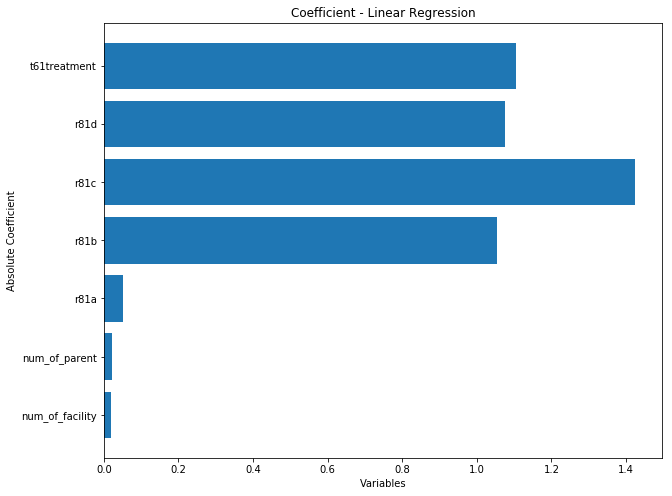

In [109]:

feat_imp = [(i) for i in (lr_model.coefficients) ]

# print(pd_dfagg.columns[1:-1])

%matplotlib inline
 
plt.figure(figsize = (10, 8))
# pos
plt.barh(pd_dfagg.columns[1:-1], feat_imp)
plt.xlabel('Variables')
plt.ylabel('Absolute Coefficient')
plt.title('Coefficient - Linear Regression')
# plt.grid(True)
plt.show()

### 2.2.2 Using Decision Tree Regressor

In [110]:
%%time
# apr 10 works regression step 4 print coefficients, intercept, RMSE, r2
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'total_release')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="total_release", predictionCol="prediction", metricName="rmse")
rmse_DecisionTreeRegressor = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_DecisionTreeRegressor)
dt_model.featureImportances

Root Mean Squared Error (RMSE) on test data = 2488.51
CPU times: user 91.4 ms, sys: 44.8 ms, total: 136 ms
Wall time: 7.93 s


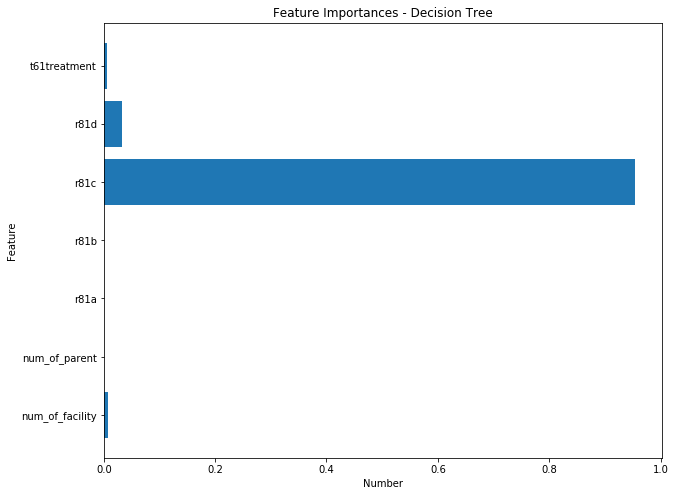

In [111]:
feat_imp = [i for i in dt_model.featureImportances ]
# print(feat_imp)
# print(len(feat_imp))
# print(pd_dfagg.columns[1:-1])

%matplotlib inline
 
plt.figure(figsize = (10, 8))
# pos
plt.barh(pd_dfagg.columns[1:-1], feat_imp)
plt.xlabel('Number')
plt.ylabel('Feature')
plt.title('Feature Importances - Decision Tree')
# plt.grid(True)
plt.show()

### 2.2.3 Using Random Forest Regressor

In [112]:
%%time
from pyspark.ml.regression import RandomForestRegressor


rf = RandomForestRegressor(featuresCol ='features', labelCol = 'total_release')
rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)
rf_evaluator = RegressionEvaluator(
    labelCol="total_release", predictionCol="prediction", metricName="rmse")
rmse_RandomForestRegressor = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_RandomForestRegressor)
rf_model.featureImportances


Root Mean Squared Error (RMSE) on test data = 3062.18
CPU times: user 104 ms, sys: 42.1 ms, total: 146 ms
Wall time: 10.2 s


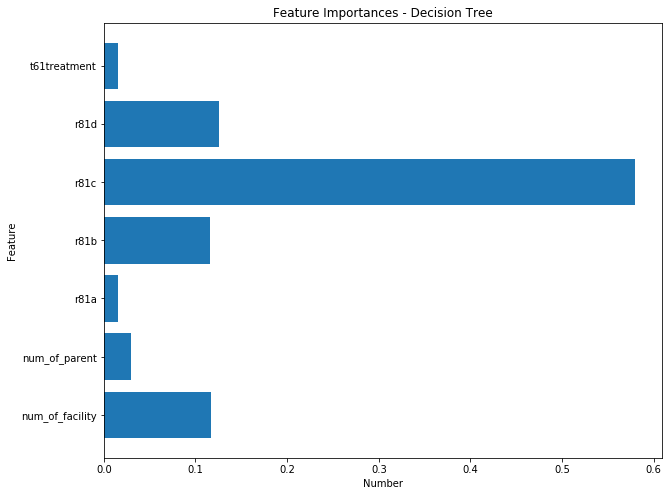

In [113]:
feat_imp = [i for i in rf_model.featureImportances ]
# print(feat_imp)
# print(len(feat_imp))
# print(pd_dfagg.columns[1:-1])

%matplotlib inline
 
plt.figure(figsize = (10, 8))
# pos
plt.barh(pd_dfagg.columns[1:-1], feat_imp)
plt.xlabel('Number')
plt.ylabel('Feature')
plt.title('Feature Importances - Decision Tree')
# plt.grid(True)
plt.show()

## Regressor Result Comparison



In [114]:
rmse_LinearRegression
Lname = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor']
Lvalue = [rmse_LinearRegression,rmse_DecisionTreeRegressor, rmse_RandomForestRegressor]
resultdf = pd.DataFrame({'Method': Lname, 'RMSE':Lvalue})
display(resultdf)

,Method,RMSE
0,LinearRegression,901.016886
1,DecisionTreeRegressor,2488.509723
2,RandomForestRegressor,3062.175678


Traditional Linear Regression method has the lowest RMSE. RandomForestRegressor has the worst RMSE. With such a small data set, choose your model carefully.

# Time Comparison

Running time was tracked and output to the following dataframe. 



In [141]:
time_linear_regression_spark = 17.9
time_DecisionTreeRegressor_spark = 7.93
time_RandomForestRegressor_spark = 10.2

time_linear_regression_local = 0.0709
time_DecisionTreeRegressor_local = 0.004
time_RandomForestRegressor_local = 0.022
Lname = ['linear_regression_spark', 'DecisionTreeRegressor_spark', 'RandomForestRegressor_spark', 
        'linear_regression_local', 'DecisionTreeRegressor_local', 'RandomForestRegressor_local']
Lvalue = [time_linear_regression_spark,time_DecisionTreeRegressor_spark, time_RandomForestRegressor_spark, 
            time_linear_regression_local, time_DecisionTreeRegressor_local, time_RandomForestRegressor_local]
resultdf = pd.DataFrame({'Type': Lname, 'Time(second)':Lvalue})
display(resultdf)

,Type,Time(second)
0,linear_regression_spark,17.9000
1,DecisionTreeRegressor_spark,7.9300
2,RandomForestRegressor_spark,10.2000
3,linear_regression_local,0.0709
4,DecisionTreeRegressor_local,0.0040
5,RandomForestRegressor_local,0.0220


Unsurprisingly, with such a small data set, local machine delivers the best result.

# Lesson Learned

#### 1. Always study the data first. 
    If there is a document explaining the data, read the document first.  
#### 2. Sample the data before design the experiement. 
    Apply the sample techniques such as simple random sampling, stratified sampling, cluster sampling, etc. 
#### 3. Don't forget the dimension reduction. 
    Use the dimension reduction technique to reduce the noise. 
#### 4. Last but the most important: Always keep the goal in mind
    Don't do things because you want to do things. Do it because it will make you closer to reaching the goal. 




# Thank you  

In [142]:
# Don't forget to stop your cluster when you are done

sc.stop()
sj.stop()
print('done')

INFO:sparkhpc.sparkjob:


done
